In [1]:
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from pylab import rcParams
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import skfda
from collections import Counter
import pygraphviz as pgv
from pyvis.network import Network
import matplotlib.colors as pltcol
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette, fcluster
from scipy.spatial.distance import squareform
from sklearn import preprocessing
from matplotlib.pyplot import figure
from IPython.display import display

In [2]:
colors = [plt.cm.Set3(i) for i in range(20)]
high_regime=colors[0]
low_regime=colors[3]
default_color=colors[4]
default_color2=low_regime
default_color3=high_regime
default_color4=colors[5]
plt.cm.get_cmap('Set3')

In [288]:
years = range(1990,2022)
for y in years:
    locals()['Gorg' + str(y)] = nx.read_gpickle(r'C:\Users\Marco\Documents\GitHub\crunch_net\ANS\ANS_all\orgorg4\orgorg4_single' +
                                               str(y) +
                                               '.gpickle')
    print(y)

1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [3]:
years = range(1994,2021)
for y in years:
    locals()['Gbid' + str(y)] = nx.read_gpickle(r'C:\Users\Marco\Documents\GitHub\crunch_net\ANS\ANS_all\bidbid_stage_self_single\bidbid_stage_self_single_' +
                                               str(y) +
                                               '.gpickle')
    print(y)

1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def hypergeom_pmf(N, A, n, x):
    
    '''
    Probability Mass Function for Hypergeometric Distribution
    :param N: population size
    :param A: total number of desired items in N
    :param n: number of draws made from N
    :param x: number of desired items in our draw of n items
    :returns: PMF computed at x
    '''
    Achoosex = comb(A,x)
    NAchoosenx = comb(N-A, n-x)
    Nchoosen = comb(N,n)
    
    return (Achoosex)*NAchoosenx/Nchoosen

In [4]:
def hypergeom_cdf(N, A, n, t, min_value=None):
    
    '''
    Cumulative Density Funtion for Hypergeometric Distribution
    :param N: population size
    :param A: total number of desired items in N
    :param n: number of draws made from N
    :param t: number of desired items in our draw of n items up to t
    :returns: CDF computed up to t
    '''
    if min_value:
        return np.sum([hypergeom_pmf(N, A, n, x) for x in range(min_value, t+1)])
    
    return np.sum([hypergeom_pmf(N, A, n, x) for x in range(t+1)])

In [5]:
def plot_degree_dist(G):
    hist = nx.degree_histogram(G)
    q = [w+1 for w in hist]
    q = np.log(q[1:])
    
    plt.subplot(7,3, y-2000)
    x = np.log(range(1, len(hist)))
    plt.plot(x, q, ".")
    plt.title(str(y))
    
    #plt.loglog()
    m, b = np.polyfit(x, q, 1)
    plt.plot(x, m*x + b)
    #print(y)
    #print(m)
    #print(' ')

In [6]:
def get_succ(status):
    if status == 'Acquired':
        return 1
    if status == 'Alive / Active':
        return 0
    if status == 'IPO / Went public':
        return 1
    if status == 'Merged':
        return 1
    if isinstance(status, float):
        if np.isnan(status):
            return np.nan
    else:
        return 0
    
    


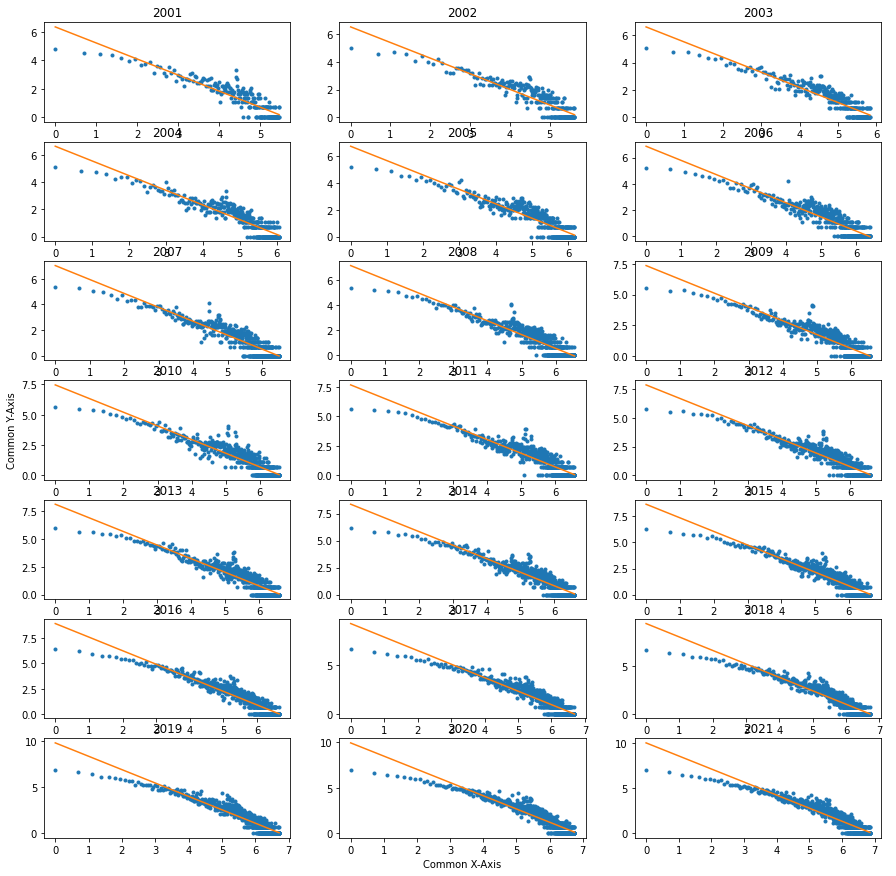

In [8]:
f, axs = plt.subplots(7,3,figsize=(15,15), sharex=True, sharey=True)

for y in range(2001,2022):
    plot_degree_dist(locals()['Gorg' + str(y)])
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Common X-Axis")
plt.ylabel("Common Y-Axis")
plt.show()

In [ ]:
orgs.columns

# Definizione Classica

In [7]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

nodes_org = cb[['target_name', 'target_ID', 'target_country', 'target_continent', 'industry', 'target_founded']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id', 'investor_country', 'investor_continent', 'investor_type', 'investor_founded']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index", 'target_founded':'foundation'})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index', 'investor_founded':'foundation' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])


In [8]:
def get_status(rounds):
    a = list()
    for i in rounds:
        indice = stage.index(i)
        a.append(stato[indice])
    return a
    
    


In [9]:
stati = cb_new.groupby('id_x')
stati2 = stati.tail(1).reset_index(drop=True)
stati3 = stati2[stati2["date"].notna()]

stati2[stati2["target_status"] == "Merged"].drop_duplicates()[["target_name","round_simp","target_status", "date"]]
fun_status = stati2[["round_simp", "target_status"]].groupby(['round_simp', "target_status"]).size().unstack(fill_value=0)[1:61]
fun_status.T.index.values

fun_status.mode()['Dead / Inactive']
stage = list(fun_status.idxmax(axis=1).index)
stage.append("Acq - P2P")

stato = list(fun_status.idxmax(axis=1))
stato.append("Acquired")

set(stato)
#robustness nel passare degli anni

{'Acquired',
 'Alive / Active',
 'Assets Purchased',
 'Dead / Inactive',
 'IPO / Went public',
 'Merged'}

In [196]:
df = cb_new
df['date_y']=df['date_y']#.dt.year
df = df[df['date_y']>0]
#df = df[df['size_real']>0]
#df = df[df['target_founded']>0]
ids = set(df['id_x'])

company = list(ids)

for i in range(5,13):
    locals()['status'+ str(i)] = []

for i in tqdm(ids):
    sub = df[df['id_x']== i][['id_x', 'date_y', 'round_simp','target_founded']]
    for l in range(5,13):
        sub1 = sub[(sub['date_y']<sub['date_y'].values[0]+l) & (sub['date_y'].values[0] < 2022-l)] #subsetto
        sub2 = sub1.tail(1)
        #company.append(i)
        roun = sub2['round_simp']
        locals()['status'+ str(l)].append(get_status(roun)) #appendo
    if i % 10000 ==0:
        print(i)

    
    
    

  0%|          | 0/46824 [00:00<?, ?it/s]

0
10000
20000
30000
40000
50000


In [197]:
for i in range(5,13):
    locals()['stati'+str(i)] = [x[0] if len(x) >= 1 else np.nan for x in locals()['status'+ str(i)]]

In [282]:
Counter(stati10)

Counter({'IPO / Went public': 1271,
         'Alive / Active': 7484,
         'Acquired': 3067,
         nan: 34656,
         'Merged': 149,
         'Dead / Inactive': 125,
         'Assets Purchased': 72})

In [199]:
dicts = {}
dicts['id']=company
for i in range(5,13):
        dicts['st'+str(i)] = locals()['stati'+str(i)]

In [200]:
df_stati = pd.DataFrame(dicts)

### Most important

In [174]:
bidders = pd.read_csv(r'C:\Users\Marco\Documents\GitHub\crunch_net\ANS\ANS_all\Covariate_bidbid_final_final2.csv') # <-- relative path
orgs = pd.read_csv(r'C:\Users\Marco\Documents\GitHub\crunch_net\ANS\ANS_all\Covariates_orgorg_final2.csv') # <-- relative path


In [175]:
nodes = pd.read_csv(r'C:\Users\Marco\Documents\GitHub\crunch_net\ANS\ANS_all\nodes.csv') # <-- relative path
covariates = pd.read_csv(r'C:\Users\Marco\Documents\GitHub\crunch_net\ANS\ANS_all\covariates.csv')

In [176]:
bidders = pd.merge(bidders, nodes, on = 'id')
orgs = pd.merge(orgs,nodes, on = 'id')

In [177]:
orgs2 = pd.merge(orgs, covariates, on = 'id')

In [19]:
covariates.columns

Index(['Unnamed: 0', 'node', 'country', 'continent', 'industry', 'foundation',
       'sector', 'stage', 'first_money', 'date', 'current_sit', 'bipartite',
       'id', 'deg_max', 'deg_min', 'deg_median', 'voterank_max',
       'voterank_min', 'voterank_median', 'clustering_max', 'clustering_min',
       'clustering_median', 'harmonic_centrality_max',
       'harmonic_centrality_min', 'harmonic_centrality_median',
       'closeness_centrality_max', 'closeness_centrality_min',
       'closeness_centrality_median', 'newman_betweenness_centrality_max',
       'newman_betweenness_centrality_min',
       'newman_betweenness_centrality_median', 'pagerank_max', 'pagerank_min',
       'pagerank_median', 'betweenness_centrality_max',
       'betweenness_centrality_min', 'betweenness_centrality_median',
       'eigenvector_centrality_max', 'eigenvector_centrality_min',
       'eigenvector_centrality_median', 'average_neighbor_degree_max',
       'average_neighbor_degree_min', 'average_neighbor_d

In [201]:
bonav = covariates#[covariates.date < covariates.foundation +3]

In [202]:
succ = []
for i in range(0, len(bonav)):
    succ.append(get_succ(bonav.iloc[i,:]['current_sit']))

In [203]:
outcome = list(set(bonav['current_sit']))
success = [get_succ(x) for x in outcome]

df_s = pd.DataFrame({'current_sit': outcome, 'success' : success})
bonav2 = pd.merge(bonav, df_s, on = 'current_sit')
bonav3 = pd.merge(bonav2, df_stati, on = 'id')

for l in range(5,13):
    locals()['succ'+str(l)]= []
    for i in tqdm(range(0,len(bonav3))):
        locals()['succ'+str(l)].append(get_succ(bonav3.iloc[i,:]['st' +str(l)]))

  0%|          | 0/15178 [00:00<?, ?it/s]

  0%|          | 0/15178 [00:00<?, ?it/s]

  0%|          | 0/15178 [00:00<?, ?it/s]

  0%|          | 0/15178 [00:00<?, ?it/s]

  0%|          | 0/15178 [00:00<?, ?it/s]

  0%|          | 0/15178 [00:00<?, ?it/s]

  0%|          | 0/15178 [00:00<?, ?it/s]

  0%|          | 0/15178 [00:00<?, ?it/s]

In [204]:
for y in range(1995,2022):
    print(y, " ", len(bonav3[bonav3.date == y]))

1995   0
1996   0
1997   1
1998   2
1999   4
2000   501
2001   416
2002   332
2003   285
2004   369
2005   364
2006   459
2007   554
2008   541
2009   677
2010   742
2011   926
2012   985
2013   1117
2014   1369
2015   1729
2016   1861
2017   1943
2018   0
2019   0
2020   0
2021   0


In [205]:
for i in range(5,13):
    bonav3['succ'+str(i)] = locals()['succ'+str(i)]

In [206]:
q = bonav3#[bonav3['foundation']>1995]
for i in list(range(5,13)):
    a = list(q['succ'+str(i)])
    b = pd.isnull(a)
   
    print(np.nansum(a)/(len(a)-sum(b)))

0.12055262571492238
0.157086815623401
0.19074683418087546
0.22003246000463714
0.2467202141900937
0.27826896230805026
0.31297709923664124
0.33726067746686306


In [184]:
centralities = bonav.columns[13:]
i = -11
cent = centralities[i]
print(cent)

num_inv


In [213]:
b12 = bonav3#[bonav3['foundation']<2013]
#b12 = b12[b12['first_money']<10000000]
b12 = b12[[cent, 'current_sit','success','stage', 'st8', 'succ10','first_money','id', 'node','st8','foundation','date']]
#b12 = b12[b12[cent].notnull()]
b12 = b12[b12['succ10'].notnull()]

In [214]:
for y in range(1995,2015):
    print(y, " ", len(b12[b12.date == y]))

1995   0
1996   0
1997   1
1998   2
1999   4
2000   501
2001   416
2002   332
2003   285
2004   369
2005   364
2006   459
2007   554
2008   541
2009   677
2010   742
2011   926
2012   68
2013   51
2014   47


 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


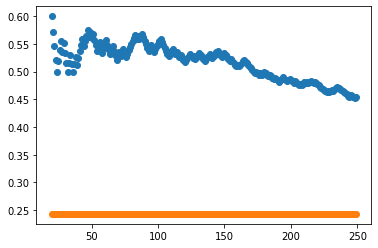

In [34]:
#FISSO WINDOW E MUOVO 
moves = []
p = []
N = len(b12)
A = int(sum(b12['succ8']))
ran = []

for i in range(20,250):
    t = int(sum(b12.sort_values(ascending=False, by = cent)[0:i]['succ8']))
    moves.append(t/i)
    n = i
    p.append(hypergeom_cdf(N, A, n, t, min_value=None))
    ran.append(A/N)
plt.scatter(range(20,250), moves)
plt.scatter(range(20,250), ran)
plt.show()

2
4
5
6
7


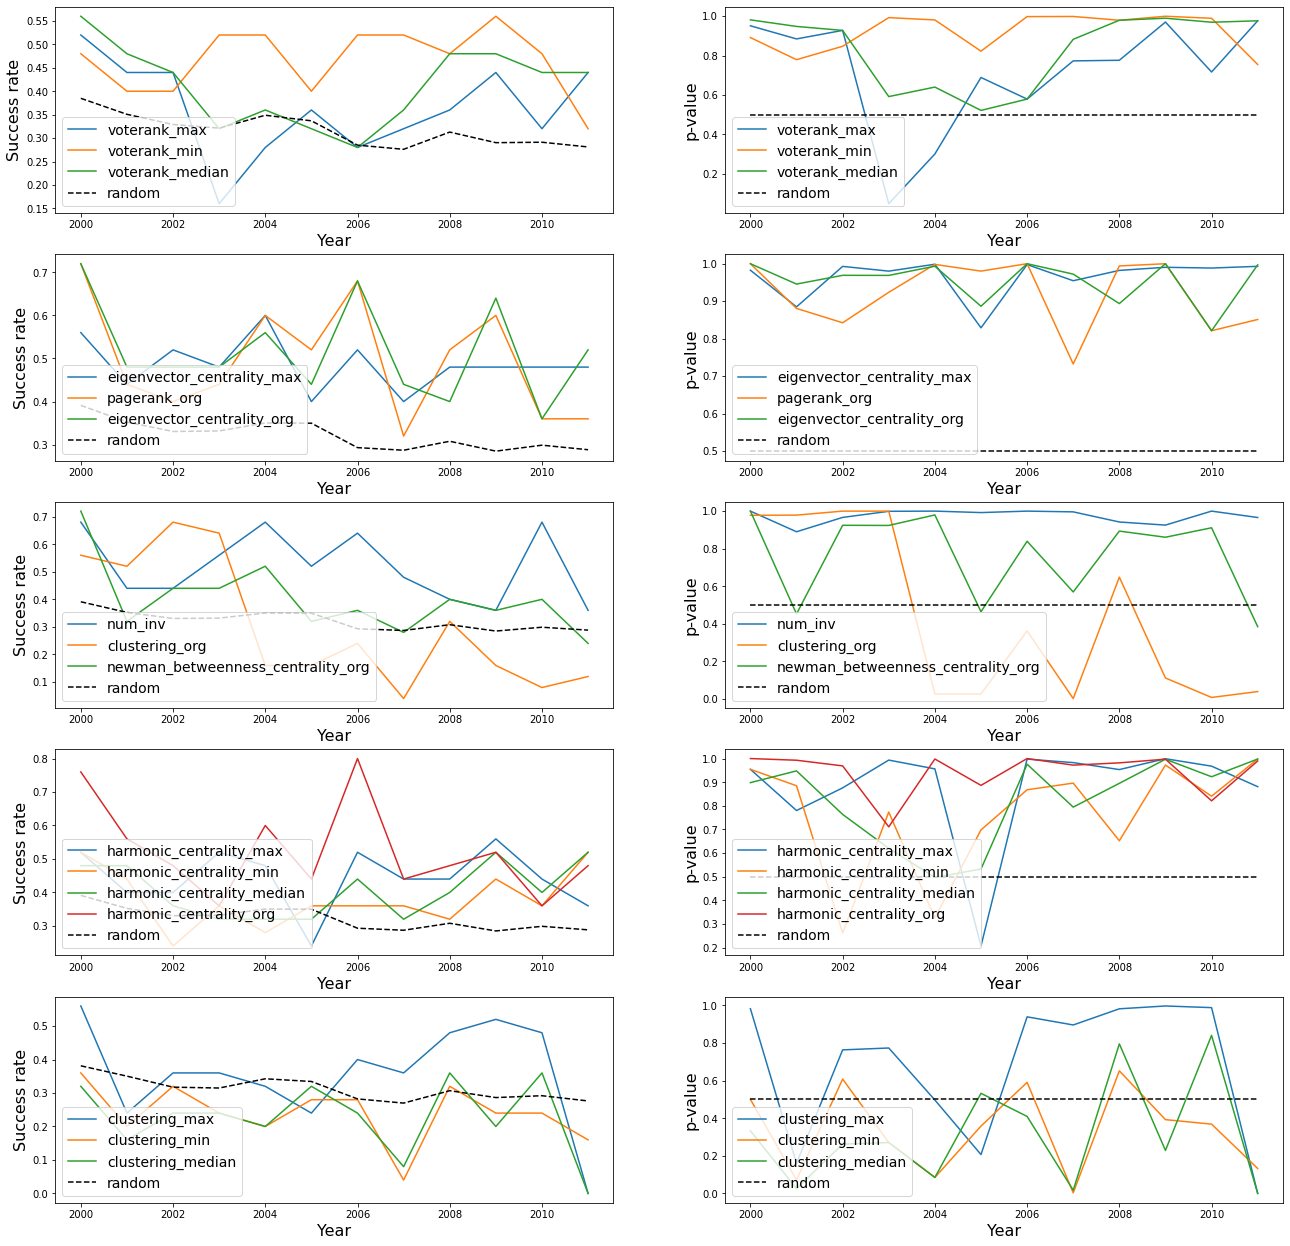

In [302]:
#FISSO AMPIEZZA SAMPLE, MUOVO ANNO INVESTIMENTO

covars = list(Z_scaled.columns)
clus = list(fl)
diz = {'covars':covars, 'clus':clus}
clus_n = range(1,8)
dataf = pd.DataFrame(diz)

fig, axs = plt.subplots(5, 2, figsize=(22, 22))
groups = [2,4,5,6,7]
yr = 10
for l in groups:
    cents = list(dataf[dataf['clus']==l]['covars'])
    print(l)
    for cent in cents:
        b12 = bonav3#[bonav3['foundation']<2013]
        #b12 = b12[b12['first_money']<10000000]
        b12 = b12[[cent, 'current_sit','success','stage', 'st8', 'succ'+str(yr),'id', 'node','date']]
        b12 = b12[b12[cent].notnull()]
        b12 = b12[b12['succ'+str(yr)].notnull()]
        moves = []
        p = []
        ran = []
        for i in range(2000,2022-yr):
            n = 25
            N = len(b12[b12['date']==i])
            A = int(sum(b12[b12['date']==i]['succ'+str(yr)]))
            ran.append(A/N)
            if cent in ['voterank_median','voterank_max','voterank_min']:
                t = int(sum(b12[b12['date']==i].sort_values(ascending=True, by = cent)[0:n]['succ'+str(yr)]))
            else:
                t = int(sum(b12[b12['date']==i].sort_values(ascending=False, by = cent)[0:n]['succ'+str(yr)]))
            moves.append(t/n)
            p.append(hypergeom_cdf(N, A, n, t, min_value=None))
            
        axs[groups.index(l),0].plot(range(2000,2022-yr), moves, label = cent)
        axs[groups.index(l),1].plot(range(2000,2022-yr), p, label = cent)
    axs[groups.index(l),0].set_xlabel('Year', fontsize=16)
    axs[groups.index(l),0].set_ylabel('Success rate', fontsize=16)
    axs[groups.index(l),1].set_xlabel('Year', fontsize=16)
    axs[groups.index(l),1].set_ylabel('p-value', fontsize=16)
    axs[groups.index(l),0].plot(range(2000,2022-yr), ran, 'k--', label = 'random')
    axs[groups.index(l),1].plot(range(2000,2022-yr), [0.5 for x in range(2000,2022-yr)], 'k--', label = 'random')
    axs[groups.index(l),0].legend(fontsize=14, loc='lower right')
    axs[groups.index(l),1].legend(fontsize=14, loc='lower tight')
plt.savefig('fivegroup' +'.pdf',  bbox_inches="tight")
plt.show()





In [268]:
cents

[]

In [264]:
N = len(b12[b12['date']==i])
A = sum(b12[b12['date']==i]['succ'+str(yr)])
print(N)
print(A)

466
131.0


num_inv
1


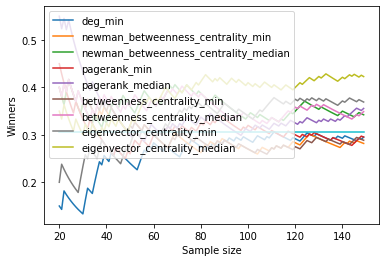

2


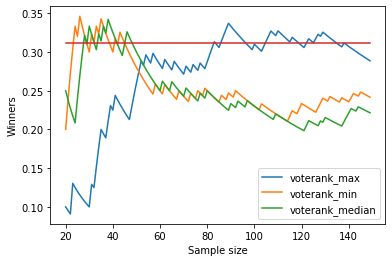

3


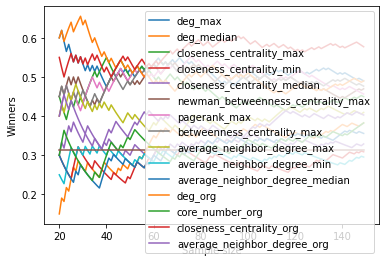

4


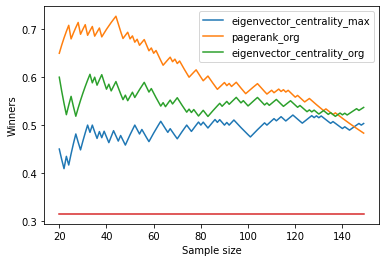

5


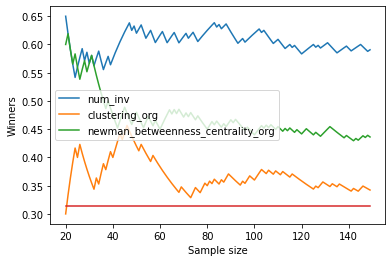

6


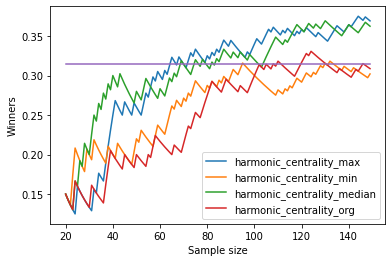

7


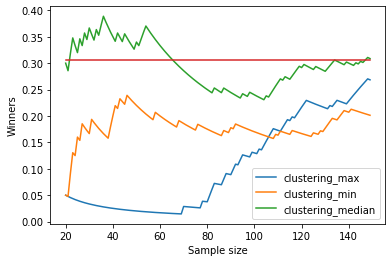

In [330]:
centralities = bonav.columns[13:]
i = -11
cent = centralities[i]
print(cent)
#......................
covars = list(Z_scaled.columns)
clus = list(fl)
diz = {'covars':covars, 'clus':clus}
clus_n = range(1,8)
dataf = pd.DataFrame(diz)


centralities = [bonav.columns[i] for i in [8] + list(range(13,len(bonav.columns)))]
for i in clus_n:
    cents = list(dataf[dataf['clus']==i]['covars'])
    print(i)
    for cent in cents:
        b12 = bonav3#[bonav3['foundation']<2013]
        #b12 = b12[b12['first_money']<10000000]
        b12 = b12[[cent, 'current_sit','success','stage', 'st8', 'succ10','id', 'node','st8']]
        b12 = b12[b12[cent].notnull()]
        b12 = b12[b12['succ10'].notnull()]
        moves = []
        p = []
        N = len(b12)
        A = int(sum(b12['succ10']))
        ran = []
        if cent in ['voterank_median','voterank_max','voterank_min']:
            b12 = b12.sort_values(ascending=True, by = cent)
        if cent == 'clustering_org':
            b12 = b12[(b12['clustering_org']!=1) & (b12['clustering_org']!=0)]
            b12 = b12.sort_values(ascending=False, by = cent)
        else:
            b12 = b12.sort_values(ascending=False, by = cent)
        for l in range(20,150):
            t = int(sum(b12[0:l]['succ10']))
            moves.append(t/l)
            n = l
            p.append(hypergeom_cdf(N, A, n, t, min_value=None))
            ran.append(A/N)
        plt.plot(range(20,150), moves, label = cent)
        #plt.plot(range(20,150), p,'--', label = 'p-value'+cent)

        
        #plt.savefig('sortcum' +'size'+'.pdf',  bbox_inches="tight")
    plt.xlabel('Sample size')
    plt.ylabel('Winners')
    plt.legend()
    plt.plot(range(20,150), ran)
    plt.savefig('hype' +str(i)+'.pdf',  bbox_inches="tight")
    plt.show()

num_inv
2
4
5
6
7


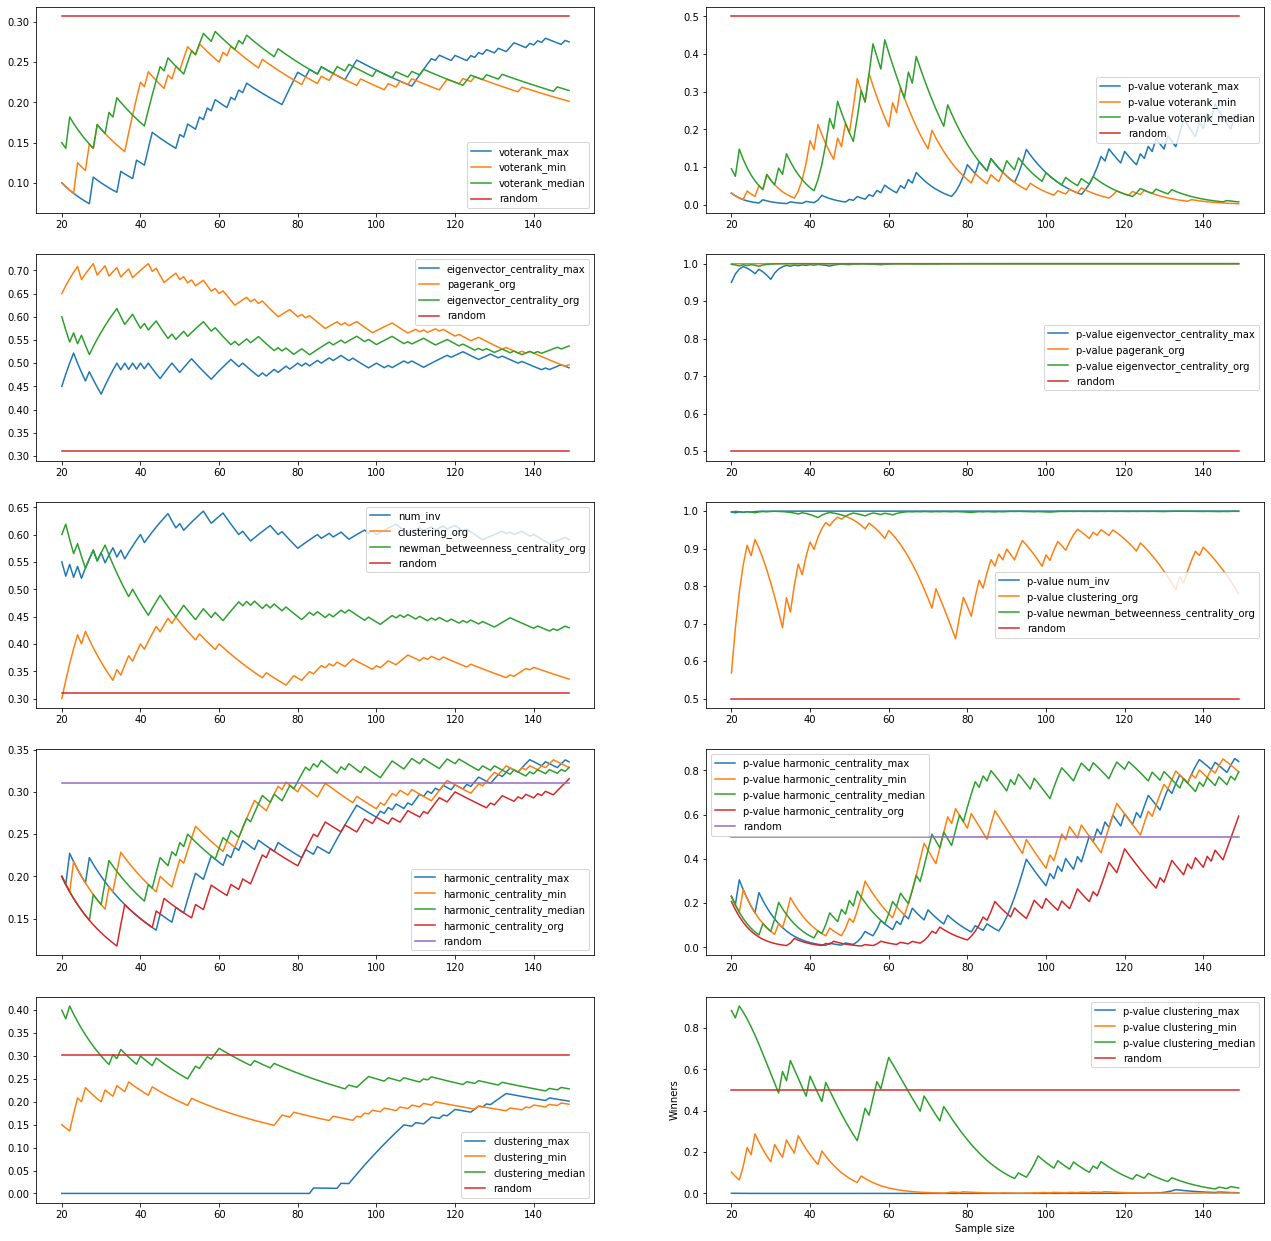

In [212]:
centralities = bonav.columns[13:]
i = -11
cent = centralities[i]
print(cent)
#......................
covars = list(Z_scaled.columns)
clus = list(fl)
diz = {'covars':covars, 'clus':clus}
clus_n = range(1,8)
dataf = pd.DataFrame(diz)

fig, axs = plt.subplots(5, 2, figsize=(22, 22))
centralities = [bonav.columns[i] for i in [8] + list(range(13,len(bonav.columns)))]
groups = [2,4,5,6,7]
for i in groups:
    cents = list(dataf[dataf['clus']==i]['covars'])
    print(i)
    for cent in cents:
        b12 = bonav3#[bonav3['foundation']<2013]
        #b12 = b12[b12['first_money']<10000000]
        b12 = b12[[cent, 'current_sit','success','stage', 'st8', 'succ10','id', 'node','st8']]
        b12 = b12[b12[cent].notnull()]
        b12 = b12[b12['succ10'].notnull()]
        moves = []
        p = []
        N = len(b12)
        A = int(sum(b12['succ10']))
        ran = []
        if cent in ['voterank_median','voterank_max','voterank_min']:
            b12 = b12.sort_values(ascending=True, by = cent)
        if cent == 'clustering_org':
            b12 = b12[(b12['clustering_org']!=1) & (b12['clustering_org']!=0)]
            b12 = b12.sort_values(ascending=False, by = cent)
        else:
            b12 = b12.sort_values(ascending=False, by = cent)
        for l in range(20,150):
            t = int(sum(b12[0:l]['succ10']))
            moves.append(t/l)
            n = l
            p.append(hypergeom_cdf(N, A, n, t, min_value=None))
            ran.append(A/N)
        axs[groups.index(i),0].plot(range(20,150), moves, label = cent)
        axs[groups.index(i),1].plot(range(20,150), p, label = 'p-value '+cent)

        
        #plt.savefig('sortcum' +'size'+'.pdf',  bbox_inches="tight")
    plt.xlabel('Sample size')
    plt.ylabel('Winners')
    axs[groups.index(i),0].plot(range(20,150), ran, label = 'random')
    axs[groups.index(i),1].plot(range(20,150), [0.5 for x in range(20,150)], label = 'random')
    axs[groups.index(i),0].legend()
    axs[groups.index(i),1].legend()
    
plt.savefig('fivegroup' +'.pdf',  bbox_inches="tight")
plt.show()

In [36]:
np.nansum(b12['succ8'])/(len(b12)-sum(pd.isnull(b12['succ8'])))

0.2430025445292621

In [ ]:
len(b12[(b12.first_money>10^6) & (b12.first_money<10^8)])

In [ ]:
for y in range(1995,2021):
    display(orgs[['closeness_centrality' + str(y), 'node', 'country', 'industry']].sort_values(ascending=False, 
                                                                                            by = 'closeness_centrality' + str(y)).iloc[0:30,:])

In [ ]:
b12.sort_values(ascending=False, by = 'closeness_centrality_org')[0:1000]

In [ ]:

sns.set(style='ticks')
_success= [0, 1]
df = pd.DataFrame({
    'centr': (b12[cent]),
    'money': np.log(b12['first_money']),
    'success': b12['succ8']
})

In [ ]:
sns.relplot(data=df, x='eigen', y='money', hue='success', hue_order=_success, aspect=1.61)
plt.show()

In [ ]:
for i in centralities:
    sns.boxplot(x = "succ8", y = i, data = b12)
    plt.show()

In [ ]:
A = nx.nx_agraph.to_agraph(Gorg2005)
H = nx.nx_agraph.from_agraph(A)

In [ ]:
len(stati_8)

In [ ]:
df_st8['st8'][150:180]

## Networkss

In [ ]:
for i in tqdm(range(1994,2021)):
    nx.set_node_attributes(locals()['Gbid' + str(i)], pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
    nx.set_node_attributes(locals()['Gbid' + str(i)], pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
    nx.set_node_attributes(locals()['Gbid' + str(i)], pd.Series(nodes.continent, index=nodes.continent).to_dict(), 'continent')
    nx.set_node_attributes(locals()['Gbid' + str(i)], pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
    nx.set_node_attributes(locals()['Gbid' + str(i)], pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
    nx.set_node_attributes(locals()['Gbid' + str(i)], pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')
    print(i)

In [ ]:
Gbid2015.edges(data = True)

### countries

In [169]:
nx.write_gexf(G, "G.gexf")

In [ ]:
plt.savefig

# INDUSTRIES

In [290]:
#AMONG 
feat = 'country'
edges = nx.to_pandas_edgelist(Gorg2020)
prova = pd.merge(edges, nodes[[feat, 'id']], how = 'left', left_on = 'source', right_on = 'id' )
prova2 =pd.merge(prova, nodes[[feat, 'id']], how = 'left', left_on = 'target', right_on = 'id' )
weight = []
sub = prova2[[feat+'_x', feat+'_y']]
sub2 = prova2[[feat+'_x', feat+'_y']].drop_duplicates()
sub3 = sub2.dropna()
for i in tqdm(range(0,len(sub3))):
    
    sub4 = sub[((sub[feat+'_x']== sub3[feat+'_x'].values[i]) & (sub[feat+'_y']== sub3[feat+'_y'].values[i]))| ((sub[feat+'_y']== sub3[feat+'_x'].values[i]) & (sub[feat+'_x']== sub3[feat+'_y'].values[i]))  ]
    peso = len(sub4)
    weight.append(peso)
sub3['weight'] = weight
prova3 = pd.merge(prova2, sub3, left_on = [feat+'_x',feat+'_y'], right_on = [feat+'_x', feat+'_y'])
prova4 = prova3[prova3[feat+'_x']<=prova3[feat+'_y']]
prova4['weight_l'] = np.log(prova4['weight']+3)


  0%|          | 0/1684 [00:00<?, ?it/s]

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_8856\2259359662.py:15: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_8856\2259359662.py:18: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'United States': Text(14.73962957329692, 16.490307058746758, 'United States'),
 'Germany': Text(3.537963054635362, 5.724083906631932, 'Germany'),
 'Italy': Text(-17.763585581621033, 39.93826216281986, 'Italy'),
 'Israel': Text(-1.4423904402758683, -35.260950667036276, 'Israel'),
 'Sweden': Text(-50.149543364355786, 24.23444046394975, 'Sweden'),
 'Ireland': Text(-15.250032651613196, -6.025748897869518, 'Ireland'),
 'Taiwan': Text(53.546796956825894, -8.971528900623882, 'Taiwan'),
 'United Kingdom': Text(7.350338713578126, -10.525335745660337, 'United Kingdom'),
 'Japan': Text(-69.17687647557287, -12.043322780077052, 'Japan'),
 'Norway': Text(66.18994294893966, -8.196473933201577, 'Norway'),
 'Switzerland': Text(22.953495455745312, 31.592365633039307, 'Switzerland'),
 'Netherlands': Text(-33.44806702313163, -17.37045018425854, 'Netherlands'),
 'Spain': Text(-30.693897771020062, 27.70818951422225, 'Spain'),
 'Canada': Text(26.600532282556074, -6.116689780986647, 'Canada'),
 'France': Tex

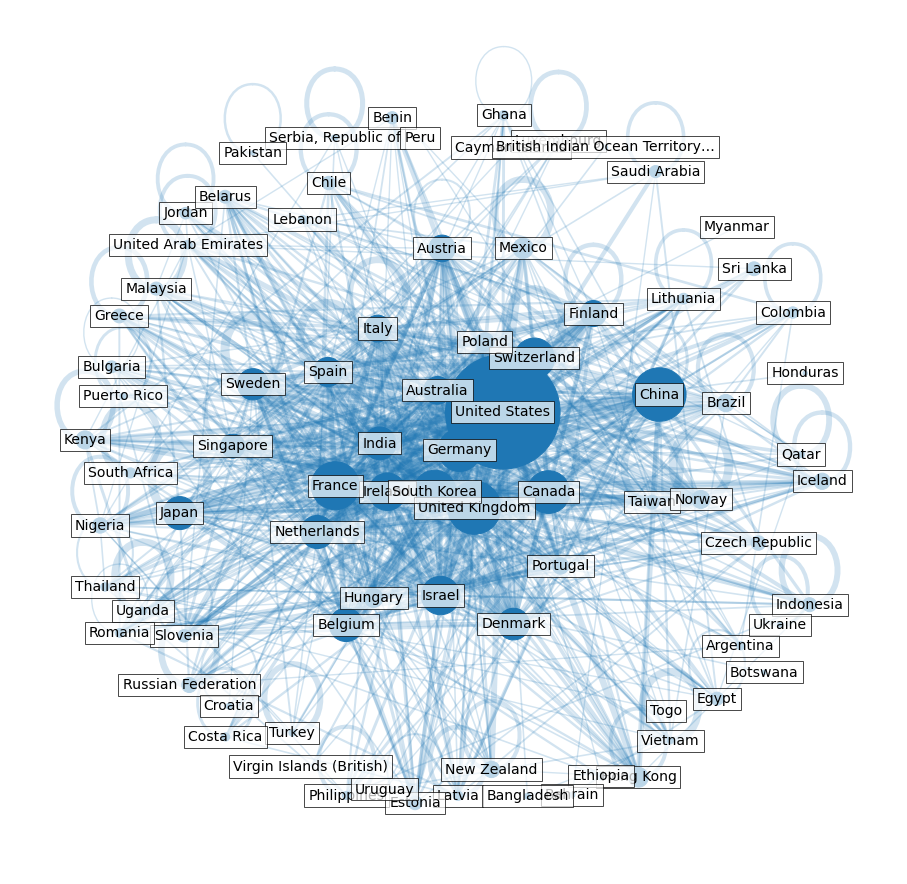

In [296]:
G = nx.from_pandas_edgelist(prova4, feat+'_x', feat+'_y', edge_attr = 'weight_l')
nodebig = [20*np.sqrt(len(prova4[(prova4[(feat +'_x')]== i)| (prova4[(feat +'_x')]== i)])) for i in list(G.nodes())]
d = dict(G.degree)
nodedeg = [d[k]*30 for k in d]
pos = nx.spring_layout(G, scale=100, k=20/np.sqrt(G.order()))

lung = len(G.edges)
edgewidth = [list(list(G.edges(data= True))[i][2].values())[0] for i in range(0,lung-1)]
fig, ax = plt.subplots(figsize=(16, 16))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.2, width=edgewidth, edge_color="tab:blue")
nx.draw_networkx_nodes(G, pos, node_size=nodebig, node_color="tab:blue", alpha=1)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)

In [294]:
leaderboard = {}
for x in G.nodes:
    leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

,connections
United States,69
United Kingdom,58
Canada,54
Germany,53
Netherlands,49
...,...
Honduras,1
Cayman Islands,1
Botswana,1
Myanmar,1


In [299]:
fig.savefig("orgcountries.pdf", bbox_inches="tight")

# confusion matrix

In [26]:
def extract_window(time_window):
    data_aligned=pd.DataFrame()
    for col in data.columns:
        first_inv_year=data.loc[~data[col].isna(), col].index[0]
        if first_inv_year>1999 and first_inv_year<2021-time_window:
            x=data.loc[first_inv_year:,col].reset_index()
            data_aligned[col]=x[col]
    data_aligned=data_aligned.fillna(0)
    data_aligned=data_aligned.cumsum()
    data_export=data_aligned.loc[0:time_window-1,:]
    return data_export

# We run K-means 100 times per sector in order to "be sure" of clustering partitions
def functional_clustering(data):
    clusters={}
    kmeans=skfda.ml.clustering.KMeans(n_clusters=2, n_init=100)
    for sector in content.industry_x.unique():
        idx=content[content.industry_x==sector].id_x
        mat=data.loc[:,data.columns.isin(idx)]
        if mat.shape[1]>1:
            fdmat = skfda.FDataGrid(mat.transpose().to_numpy())
            labels=kmeans.fit_predict(fdmat)
            if kmeans.cluster_centers_.evaluate(0.5)[1]>kmeans.cluster_centers_.evaluate(0.5)[0]:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]=x[1]
            else:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]= 0 if x[1]==1 else 1
    return clusters

In [275]:

data=cb_new[['target_name', 'industry_x', 'id_x', 'date_y', 'size_real', 'target_founded', 'target_status', 'round_simp']]
data.date_y=data.date_y#.dt.year
a=data.groupby(['round_simp']).count()
a['target_name']=a.target_name/data.shape[0]
remove=['Asset Sale', 'Bridge', 'Dead', 'Debt', 'Distressed & Special Situation', 'Leveraged Buyout', 'Line of Credit', 
 'Loan', 'Management Buyout', 'Milestone Payment', 'Other Investors', 'Portfolio Merger', 'Portfolio NewCo',
 'Secondary Market', 'Shareholder Liquidity']

data=data[data.size_real>0]
#data=data[~data.target_founded.isna()]
data=data[data.date_y<2021]
data=data.loc[data.industry_x.isna()==False,]
data=data.loc[~data.round_simp.isin(remove)]

content=data[['industry_x','id_x', 'target_name', 'target_founded', 'target_status']].drop_duplicates()
content['alive']=np.where(content.target_status.isin(['Alive / Active']),1,0)

data=data.groupby(['id_x','target_name','date_y']).mean().reset_index()
data=data.pivot('date_y','id_x','size_real')

 c:\python38\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [89]:
percentage=[]

for size in tqdm(range(5,13)):
    locals()['data_size' + str(size)]= extract_window(size)
    locals()['data_size' + str(size)]= locals()['data_size' + str(size)].loc[:, (locals()['data_size' + str(size)] != locals()['data_size' + str(size)].iloc[0]).any()]
    #data_size = np.log(data_size)
    locals()['clusters'+str(size)] = functional_clustering(locals()['data_size' + str(size)])
    percentage.append(sum(locals()['clusters'+str(size)].values())/len(locals()['clusters'+str(size)].values()))
    print(size)

  0%|          | 0/8 [00:00<?, ?it/s]

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\513735609.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


5
6
7
8
9
10
11
12


In [277]:
os.chdir(r'C:\Users\Marco\Documents\GitHub\crunch_net\ANS\ANS_all\orgorg4')
for i in range(5,13):
    locals()['data_size'+str(i)] = pd.read_csv('data_size'+str(i)+'.csv')
    locals()['data_size'+str(i)] = locals()['data_size'+str(i)].loc[:, ~locals()['data_size'+str(i)].columns.str.contains('^Unnamed')]
    locals()['clusters'+str(i)] = pd.read_csv('clusters'+str(i)+'.csv')
    locals()['clusters'+str(i)] = locals()['clusters'+str(i)].loc[:, ~locals()['clusters'+str(i)].columns.str.contains('^Unnamed')]

In [90]:
for i in range(5,13):
    locals()['data_size'+str(i)].to_csv('data_size'+str(i)+'.csv')
    pd.DataFrame(locals()['clusters'+str(i)].keys(), locals()['clusters'+str(i)].values()).reset_index().to_csv('clusters'+str(i)+'.csv')

In [278]:
clusters12

,index,0
0,0,64
1,0,79
2,0,121
3,0,206
4,0,209
...,...,...
2287,1,9690
2288,0,10515
2289,0,11009
2290,0,12439


In [279]:
data_size=data_size.loc[:, (data_size != data_size.iloc[0]).any()]
clusters=functional_clustering(data_size)
print('Percentage of successful firms:', 100*sum(clusters.values())/len(clusters.values()), '%')

NameError: name 'data_size' is not defined

In [280]:
#SUCCESSO CLASSICO 
classic = bonav3[['id','succ10']]
classic = classic[classic['succ10'].notnull()]
classic = dict(zip(classic.id, classic.succ10))
cluster10 = dict(zip(clusters10['0'],clusters10['index']))
a = cluster10.keys() #take companies present in clusters10
b = classic.keys() #take companies with classic success
c = list(set(a) & set(b)) #intersection
classic = dict((k, classic[k]) for k in c)
new = dict((k, cluster10[k]) for k in c)
y_clas = list(classic.values())
y_new = list(new.values())
#confusion_matrix(y_clas, y_new)

y_actu = pd.Series(y_clas, name='clas')
y_pred = pd.Series(y_new, name='new')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

new,0,1
clas,,
0.0,1889,225
1.0,664,294


In [59]:
clusters10[]'

,index,0
0,0,64
1,0,79
2,0,121
3,0,206
4,0,209
...,...,...
3067,0,11009
3068,0,12439
3069,0,13131
3070,0,14072


In [102]:
import os
os.chdir(r'C:\Users\Marco\Documents\GitHub\crunch_net\ANS\ANS_all')
covariates=pd.read_csv('covariates.csv', index_col=0)
covariates2 =pd.read_csv('covariates.csv')
#covariates=covariates.drop(['voterank_max', 'voterank_min', 'voterank_median', 'voterank_org'], axis=1)
#covariates=covariates.drop(['voterank_org'], axis=1)

In [103]:
# Transformations (plotted and chosen individually)
covariates['first_money']=np.log(covariates['first_money'])
covariates['deg_max']=np.log(covariates['deg_max'])
covariates['deg_min']=np.log(covariates['deg_min'])
covariates['deg_median']=np.log(covariates['deg_median'])
covariates['newman_betweenness_centrality_max']=np.log(covariates['newman_betweenness_centrality_max']+0.001)
covariates['newman_betweenness_centrality_min']=np.log(covariates['newman_betweenness_centrality_min']+0.001)
covariates['newman_betweenness_centrality_median']=np.log(covariates['newman_betweenness_centrality_median']+0.001)
covariates['pagerank_max']=np.log(covariates['pagerank_max'])
covariates['pagerank_min']=np.log(covariates['pagerank_min'])
covariates['pagerank_median']=np.log(covariates['pagerank_median'])
covariates['betweenness_centrality_max']=np.log(covariates['betweenness_centrality_max']+0.001)
covariates['betweenness_centrality_min']=np.log(covariates['betweenness_centrality_min']+0.001)
covariates['betweenness_centrality_median']=np.log(covariates['betweenness_centrality_median']+0.001)
covariates['average_neighbor_degree_max']=np.log(covariates['average_neighbor_degree_max'])
covariates['average_neighbor_degree_min']=np.log(covariates['average_neighbor_degree_min'])
covariates['average_neighbor_degree_median']=np.log(covariates['average_neighbor_degree_median'])
covariates['num_inv']=np.log(covariates['num_inv'])
covariates['deg_org']=np.log(covariates['deg_org'])
covariates['core_number_org']=np.log(covariates['core_number_org'])
covariates['newman_betweenness_centrality_org']=np.log(covariates['newman_betweenness_centrality_org']+0.0001)
covariates['pagerank_org']=np.log(covariates['pagerank_org'])

covariates['foundation']=covariates.foundation.apply(str)
covariates['date']=covariates.date.apply(str)

In [104]:
Z=covariates.drop(['node','country','continent','industry','foundation','sector', 'stage', 'first_money', 'date', 'current_sit', 'bipartite','id', 'voterank_org'], axis=1)

Z=Z.dropna()

scaler = preprocessing.StandardScaler().fit(Z)
Z_scaled = scaler.transform(Z)
Z_scaled=pd.DataFrame(Z_scaled)
Z_scaled.columns=Z.columns
Z_scaled.shape

(7921, 40)

In [64]:
colors = [plt.cm.Set3(i) for i in range(20)]
high_regime=colors[0]
low_regime=colors[3]
default_color=colors[4]
default_color2=low_regime
default_color3=high_regime
default_color4=colors[5]
plt.cm.get_cmap('Set3')

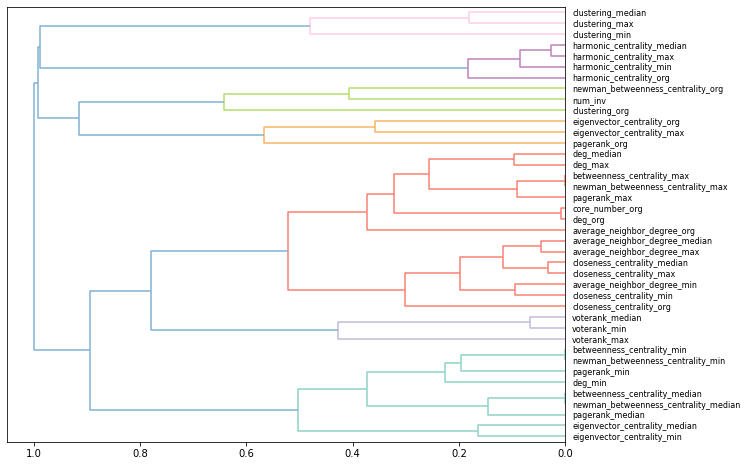

In [105]:
Z_scaled.corr().reset_index()#.iloc[22,:]
link = linkage(squareform(Z_scaled.corr().apply(lambda x: 1- np.abs(x))), method='complete')
fig = plt.figure(figsize=(10, 8))
set_link_color_palette([pltcol.rgb2hex(colors[0]), pltcol.rgb2hex(colors[2]), pltcol.rgb2hex(colors[3]), pltcol.rgb2hex(colors[5]), pltcol.rgb2hex(colors[6]), pltcol.rgb2hex(colors[9]), pltcol.rgb2hex(colors[7])])
dn=dendrogram(link, labels=Z.columns, leaf_rotation=0, above_threshold_color=pltcol.rgb2hex(default_color), orientation='left')
#plt.title('Feature dendrogram')
n_cluster=np.unique(dn['leaves_color_list']).shape[0]
fl = fcluster(link, t=n_cluster, criterion='maxclust')

In [112]:
cumulate=data_size10.loc[data_size10.shape[0]-1,:]
cumulate=pd.DataFrame(cumulate).reset_index()
cumulate.columns=['idx', 'cum']

cumulate['cum2']=cumulate['cum']
cumulate['cum']=cumulate.cum.apply(np.log)
cumulate['idx'] = cumulate['idx'].apply(int)
covariates['id']=covariates.id.apply(float)
covariates['id']=covariates['id'].apply(int)
covariates['first_money_l']=covariates2['first_money']

In [115]:
# Scale both X and y
cumulative_me=pd.merge(cumulate, covariates, left_on='idx', right_on='id')
cumulative_me.index=cumulative_me.idx
cumulative_me=cumulative_me.drop(['node', 'id', 'bipartite', 'idx'], axis=1)


In [120]:
# Scale only X
cumulative_merge=covariates.copy()
cumulative_merge.index=cumulative_merge.id
cumulative_merge=cumulative_merge.drop(['node', 'id', 'bipartite'], axis=1)

cat=cumulative_merge.select_dtypes(exclude=['float64', 'int64'])
num=cumulative_merge.select_dtypes(include=['float64', 'int64'])

scaler = preprocessing.StandardScaler().fit(num)
num_scaled = scaler.transform(num)
num_scaled=pd.DataFrame(num_scaled)
num_scaled.columns=num.columns
num_scaled.index=cat.index

cumulative_merge=pd.concat([cat, num_scaled], axis=1)
cumulative_merge=pd.merge(cumulate, cumulative_merge, left_on='idx', right_index=True)
cumulative_merge.index=cumulative_merge['idx']

#cumulative_merge['diff_y']=cumulative_merge.cum-cumulative_merge.first_money

In [110]:
cat=cumulative_merge.select_dtypes(exclude=['float64', 'int64'])
num=cumulative_merge.select_dtypes(include=['float64', 'int64'])


In [125]:
cumulative_me['diff_y'] = cumulative_me['cum2']-cumulative_me['first_money_l']
cumulative_merge['diff_y'] = cumulative_me['diff_y']
cumulative_merge['diff_log']=np.log(cumulative_merge['diff_y'])

 c:\python38\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:invalid value encountered in log


In [139]:
cumulative_merge['diff_log']-cumulative_merge['cum']

idx
17      -0.239559
23      -0.072221
26      -0.073456
32      -0.621766
36      -0.214012
           ...   
15732   -1.225724
15736   -0.449334
15746   -0.539053
15755   -0.247170
15756   -0.024040
Length: 3072, dtype: float64

In [142]:
formula='diff_y ~ deg_min + voterank_min + average_neighbor_degree_max + eigenvector_centrality_max + clustering_org + harmonic_centrality_min + clustering_min + sector + first_money'

In [283]:
formula='diff_log ~ pagerank_median + voterank_max + average_neighbor_degree_max + eigenvector_centrality_org + clustering_org + harmonic_centrality_median + clustering_min + sector'
results = smf.ols(formula, data=cumulative_merge).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               diff_log   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     48.11
Date:                Sun, 13 Feb 2022   Prob (F-statistic):           2.02e-93
Time:                        11:41:15   Log-Likelihood:                -3529.9
No. Observations:                1917   AIC:                             7084.
Df Residuals:                    1905   BIC:                             7150.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [286]:
print(results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                           &    diff\_log     & \textbf{  R-squared:         } &     0.217   \\
\textbf{Model:}                                   &       OLS        & \textbf{  Adj. R-squared:    } &     0.213   \\
\textbf{Method:}                                  &  Least Squares   & \textbf{  F-statistic:       } &     48.11   \\
\textbf{Date:}                                    & Sun, 13 Feb 2022 & \textbf{  Prob (F-statistic):} &  2.02e-93   \\
\textbf{Time:}                                    &     11:45:45     & \textbf{  Log-Likelihood:    } &   -3529.9   \\
\textbf{No. Observations:}                        &        1917      & \textbf{  AIC:               } &     7084.   \\
\textbf{Df Residuals:}                            &        1905      & \textbf{  BIC:               } &     7150.   \\
\textbf{Df Model:}                                &          11      & \textbf{                     } &             \\
\t

In [287]:
for table in results.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &    diff\_log     & \textbf{  R-squared:         } &    0.217  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    0.213  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    48.11  \\
\textbf{Date:}             & Sun, 13 Feb 2022 & \textbf{  Prob (F-statistic):} & 2.02e-93  \\
\textbf{Time:}             &     11:50:44     & \textbf{  Log-Likelihood:    } &  -3529.9  \\
\textbf{No. Observations:} &        1917      & \textbf{  AIC:               } &    7084.  \\
\textbf{Df Residuals:}     &        1905      & \textbf{  BIC:               } &    7150.  \\
\textbf{Df Model:}         &          11      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabular}{lccc

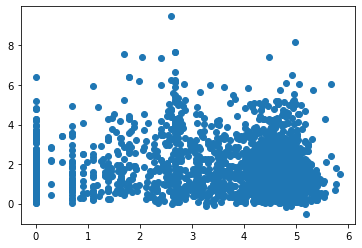

In [93]:
plt.scatter(cumulative_merge['average_neighbor_degree_max'], cumulative_merge['cum']-cumulative_merge['first_money'])

In [97]:
cumulate

,idx,cum
0,17,18.440230
1,23,18.502394
2,26,18.249071
3,32,16.503299
4,36,13.842713
...,...,...
3067,15732,17.615900
3068,15736,13.534997
3069,15746,14.908258
3070,15755,18.145349


In [115]:
predizione = cumulative_merge[['deg_min','voterank_min','average_neighbor_degree_max','eigenvector_centrality_max','clustering_org','harmonic_centrality_min',
                               'clustering_min','sector','first_money']]
predizione = predizione.dropna()
predizione = results.predict(predizione)
pred =  list(predizione)
a = {'id' : list(predizione.index), 'pred' : pred}
a = pd.DataFrame(a)
classic = bonav3[['id','succ11']]
classic = classic[classic['succ11'].notnull()]
b = pd.merge(a, classic, how = 'inner')
b.sort_values(by=['pred'], ascending=False)

,id,pred,succ11
834,10485,1.668131,0.0
1653,14216,1.592013,1.0
875,10598,1.573131,1.0
1533,13550,1.528318,1.0
475,8792,1.488413,1.0
...,...,...,...
1681,14352,-1.737513,0.0
358,5118,-1.746006,1.0
1397,12982,-1.908927,0.0
805,10387,-1.969546,0.0


 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


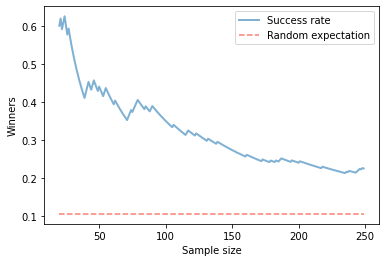

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


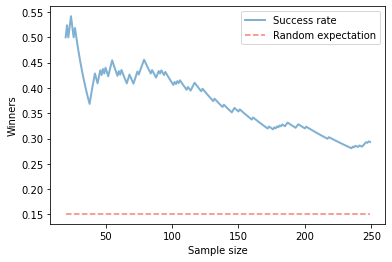

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


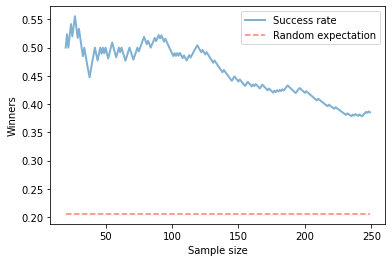

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


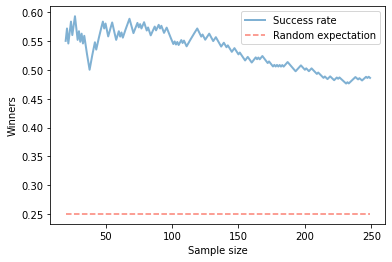

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


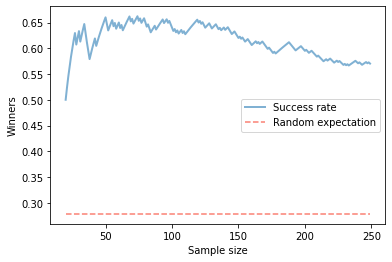

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


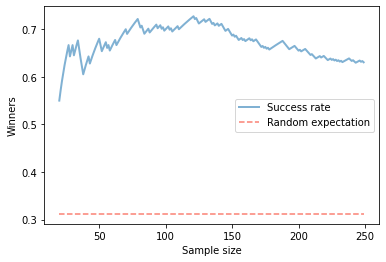

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


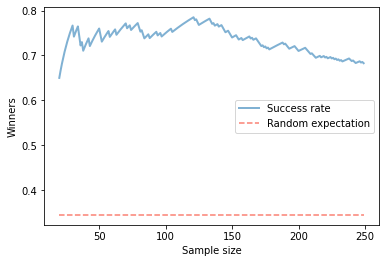

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:overflow encountered in double_scalars
 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\3412282562.py:19: RuntimeWarning:invalid value encountered in double_scalars


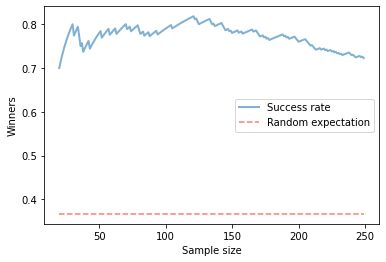

In [177]:
for size in range(5,13):
    classic = bonav3[['id','succ'+str(size)]]
    classic = classic[classic['succ' + str(size)].notnull()]
    a = cumulative_merge
    a['id'] = a.index
    b = pd.merge(a, classic, how = 'inner')
    b = b.sort_values(by=['cumlog'], ascending=False)
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    moves = []
    p = []
    N = len(b)
    A = int(sum(b['succ' + str(size)]))
    ran = []
    z = []
    for i in range(20,250):
        t = int(sum(b[0:i]['succ' + str(size)]))
        moves.append(t/i)
        n = i
        p.append(hypergeom_cdf(N, A, n, t, min_value=None))
        z.append(0.5)
        ran.append(A/N)
    plt.plot(range(20,250), moves, c=default_color, linewidth=2, label="Success rate")
    plt.plot(range(20,250), ran, ls = "--", c=default_color2, label ="Random expectation")
    plt.xlabel('Sample size')
    plt.ylabel('Winners')
    plt.legend()
    plt.savefig('sortcum' +'size'+'.pdf',  bbox_inches="tight")
    
    plt.show()


In [143]:
#for size in range(5,12):
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    moves = []
    p = []
    N = len(b)
    A = int(sum(b['succ' + str(size)]))
    ran = []
    z = []
    for i in range(20,250):
        t = int(sum(b[0:i]['succ' + str(size)]))
        moves.append(t/i)
        n = i
        p.append(hypergeom_cdf(N, A, n, t, min_value=None))
        z.append(0.5)
        ran.append(A/N)
    plt.plot(range(20,250), moves, c=default_color, linewidth=2, label="Success rate")
    plt.plot(range(20,250), ran, ls = "--", c=default_color2, label ="Random expectation")
    plt.xlabel('Sample size')
    plt.ylabel('Winners')
    plt.legend()
    plt.savefig('sortcum' +'size'+'.pdf',  bbox_inches="tight")
    
    plt.show()


IndentationError: unexpected indent (3417613723.py, line 2)

success5


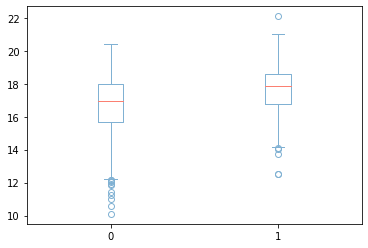

success6


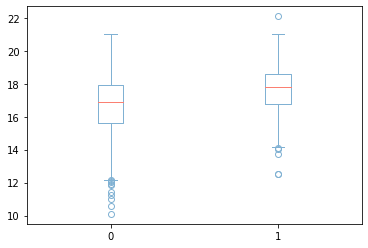

success7


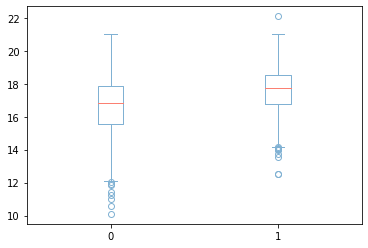

success8


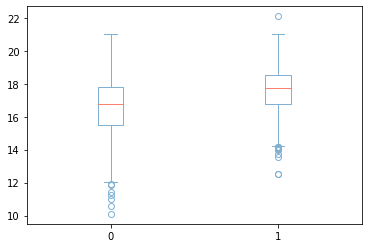

success9


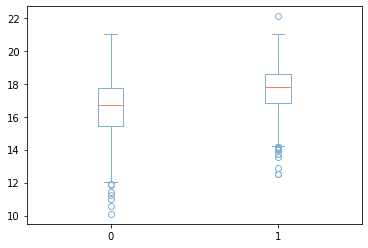

success10


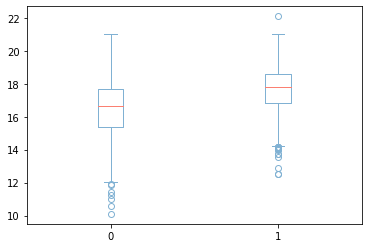

success11


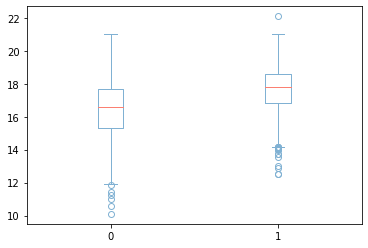

success12


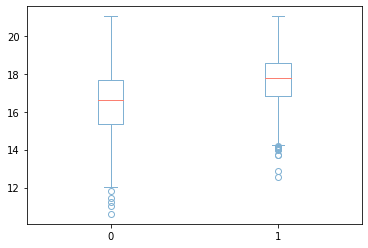

In [281]:
for size in range(5,13):
    print("success"+str(size))
    classic = bonav3[['id','succ'+str(size)]]
    classic = classic[classic['succ' + str(size)].notnull()]
    a = cumulative_merge
    a['id'] = a.index
    b = pd.merge(a, classic, how = 'inner')
    b = b.sort_values(by=['cum'], ascending=False)
    c = b[['cum','succ'+str(size)]]
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    data_1 =  np.array(c[c['succ'+str(size)]==0]['cum'])
    data_2 = np.array(c[c['succ'+str(size)]==1]['cum'])
    data = [data_1, data_2]
    labels = ['0','1']
    colors = [default_color, default_color2, default_color3]
    colors_1 = dict(color=colors[0])
    colors_2 = dict(color=colors[1])
    colors_3 = dict(color=colors[2]) 
    ax.boxplot(data_1, positions=[1], labels=['0'], boxprops=colors_1, medianprops=colors_2, whiskerprops=colors_1, capprops=colors_1, flierprops=dict(markeredgecolor=colors[0]))
    ax.boxplot(data_2, positions=[2], labels=['1'], boxprops=colors_1, medianprops=colors_2, whiskerprops=colors_1, capprops=colors_1, flierprops=dict(markeredgecolor=colors[0]))
    #ax.boxplot(dataset[2], positions=[3], labels=[labels[2]], boxprops=colors_virginica, medianprops=colors_virginica, whiskerprops=colors_virginica, capprops=colors_virginica, flierprops=dict(markeredgecolor=colors[2]))
    
    #plt.legend()
    plt.savefig('box' +str(size)+'.pdf',  bbox_inches="tight")
    
    plt.show()


# curiosities for ANS

In [253]:
len(cb_new)

187804

In [254]:
nodes

,node,index,country,continent,industry,foundation,bipartite,id
0,Shionogi & Co.,262824.0,Japan,Asia,Pharmaceuticals / Drugs,1878.0,1,0
1,Astellas Pharma,243168.0,Japan,Asia,Pharmaceuticals / Drugs,1923.0,1,1
2,Sumitomo Dainippon Pharma,447180.0,Japan,Asia,Pharmaceuticals / Drugs,1897.0,1,2
3,Konica Minolta,57191.0,Japan,Asia,Medical Devices & Equipment,1936.0,1,3
4,Takeda Pharmaceutical,373007.0,Japan,Asia,Pharmaceuticals / Drugs,1781.0,1,4
...,...,...,...,...,...,...,...,...
83253,Shenzhen Qianhai Beizeng Asset Management Co. ...,179782.0,China,Asia,Venture Capital,2016.0,0,83253
83254,Wuxi High-Tech District Seed Fund,189318.0,China,Asia,Other,NaN,0,83254
83255,Edvantage Group,190377.0,China,Asia,Corporation,2015.0,0,83255
83256,Healgen,NaN,NaN,NaN,NaN,NaN,0,83256


In [257]:
nodes[nodes['node'].duplicated()]

,node,index,country,continent,industry,foundation,bipartite,id
1256,Aspen Healthcare,229994.0,United Kingdom,Europe,Medical Facilities & Services,1998.0,1,1256
2435,Raiing,339218.0,China,Asia,Medical Devices & Equipment,NaN,1,2435
2534,Bausch Health,355655.0,Canada,North America,Pharmaceuticals / Drugs,1960.0,1,2534
3503,Escala Medical,552121.0,Israel,Asia,Medical Facilities & Services,NaN,1,3503
3528,ConvaTec,567555.0,United Kingdom,Europe,Medical Devices & Equipment,1978.0,1,3528
...,...,...,...,...,...,...,...,...
83220,Recro Pharma,208278.0,United States,North America,NaN,2011.0,0,83220
83247,HiberCell,208349.0,United States,North America,NaN,2019.0,0,83247
83248,STRATA Skin Sciences,90030.0,United States,North America,Corporation,NaN,0,83248
83256,Healgen,NaN,NaN,NaN,NaN,NaN,0,83256


In [313]:
duration =cb_n[['target_name','stage','target_founded']]
duration = duration[duration['stage']=="IPO"]
duration = duration[duration['target_founded']>1990]
ipoes =list( duration['target_name'])


In [316]:
durata=[]
cb_n = cb_new[cb_new['date_y'].dt.year>0]
cb_n['date_yr'] = cb_n['date_y'].dt.year
sub0 = cb_n[['target_name','date_yr','target_founded']]
for i in tqdm(ipoes):
    sub = sub0[sub0['target_name']==i]
    date =list(sub['date_yr'])
    diff = date[-1] -date[0]
    if diff>0:
        durata.append(diff)
    if len(durata)%100 ==0:
        print(len(durata)/len(ipoes))

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18824\1208937537.py:3: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/1502 [00:00<?, ?it/s]

0.06657789613848203
0.06657789613848203
0.13315579227696406
0.19973368841544606
0.19973368841544606
0.2663115845539281
0.2663115845539281
0.2663115845539281
0.33288948069241014
0.3994673768308921
0.46604527296937415
0.46604527296937415
0.5326231691078562
0.5326231691078562
0.5992010652463382
0.6657789613848203
0.6657789613848203
0.7323568575233023
0.7323568575233023
0.7323568575233023
0.7989347536617842


In [322]:
np.mean(durata)

8.145214521452145